In [1]:
from aug_6_utilities import *

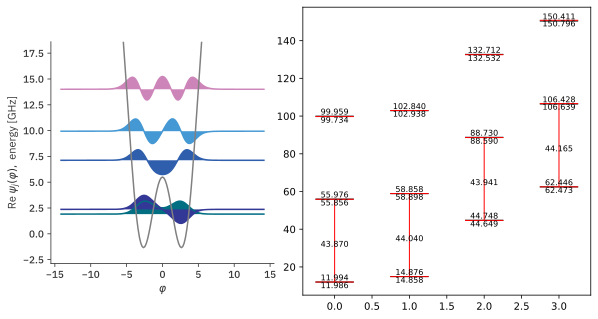

In [2]:
qubit_levels = 5
osc_levels = 6
fluxonium =  Fluxonium(EJ = 5.5,
                        EC =1.3,
                        EL = 1,
                        flux = 0.5,
                        cutoff = 110,
                        truncated_dim = qubit_levels)

osc = Oscillator(
    E_osc = 7,
    l_osc = 1,
    truncated_dim=osc_levels
)
hilbertspace = HilbertSpace([fluxonium, osc])
g = 0.3


hilbertspace.add_interaction(
    g_strength=g, op1=fluxonium.n_operator, op2=osc.creation_operator, add_hc=True
)
hilbertspace.generate_lookup()

plot_specturum(fluxonium, osc, hilbertspace)

In [3]:

# scqubit.hilbertspace.dressed_index() return None when max_overlap^2 is less than 0.5, 
# So I need a custom function where I can adjust the threshold
product_to_dressed = generate_single_mapping(hilbertspace.hamiltonian())

# Work in energy eigenbasis
a = hilbertspace.op_in_dressed_eigenbasis(op=osc.annihilation_operator)
a_dag = hilbertspace.op_in_dressed_eigenbasis(op=osc.creation_operator)

a = qutip.Qobj(a[:, :])# So that everything that goes into mesolve is like a product
a_dag =  qutip.Qobj(a[:, :])

(evals,) = hilbertspace["evals"]
diag_dressed_hamiltonian = (
        2 * np.pi * qutip.Qobj(np.diag(evals),
        dims=[hilbertspace.subsystem_dims] * 2)
)
diag_dressed_hamiltonian = qutip.Qobj(diag_dressed_hamiltonian[:, :])

def transition_frequency(s0: int, s1: int) -> float:
    return ((
            hilbertspace.energy_by_dressed_index(s1)
            - hilbertspace.energy_by_dressed_index(s0)
        ))


w_d = transition_frequency(product_to_dressed[(2,0)], product_to_dressed[(2,1)])
# w_d = transition_frequency(product_to_dressed[(0,0)], product_to_dressed[(0,1)])/2+transition_frequency(product_to_dressed[(1,0)], product_to_dressed[(1,1)])/2




tot_time = 100
tlist = np.linspace(0, tot_time, tot_time*2)

matrix_element_driven = abs((a+a_dag).data.toarray()[product_to_dressed[(2,0)]][product_to_dressed[(2,1)]])


A_Gaussian = drive_strength_for_gaussian_pulse_given_total_time(tot_time)
A_Gaussian = A_Gaussian/matrix_element_driven
def gaussian_cos(t,*args):
    gaussian_envelop =  gaussian(t, A_Gaussian, tot_time)
    cos = np.cos(w_d * 2*np.pi * t)
    return  2*np.pi * gaussian_envelop * cos

A_square = 1/tot_time
A_square = A_square/matrix_element_driven
def square_cos(t,*args):
    cos = np.cos(w_d * 2*np.pi * t)
    return  2*np.pi *A_square * cos

H_with_drive = [
    diag_dressed_hamiltonian,
    [a+a.dag(), square_cos]]



tot_time = tot_time * 2
tlist = np.linspace(0, tot_time, tot_time*2)


product_states = [(0, 0), (1, 0), (2,0), (3,0),  (0, 1), (1, 1), (2,1),(3,1)]
idxs = [product_to_dressed[(s1, s2)] for (s1, s2) in product_states]
qutip_states = [qutip.basis(hilbertspace.dimension, idx) for idx in idxs]

results = []
for i in range(4):
    temp = qutip.mesolve(
        H = H_with_drive,
        rho0 = qutip.basis(hilbertspace.dimension, product_to_dressed[(i,0)]),
        tlist = tlist,
        e_ops=[state * state.dag() for state in qutip_states]+[a,
                                                               a.dag()*a,
                                                             ],
        options=qutip.Options(store_states=True)
    )
    results.append(temp)


In [4]:
dominant_freq = []
for i in range(4):
    dominant_freq.append(find_dominant_frequency(results[i].expect[-2],tlist))

# It's strange that the dominant frequency is different from drive frequency
dominant_freq, w_d/2/np.pi

([0.9875250000000001,
  0.9725625000000001,
  0.9825375000000002,
  0.9875250000000001],
 1.1130435473675693)

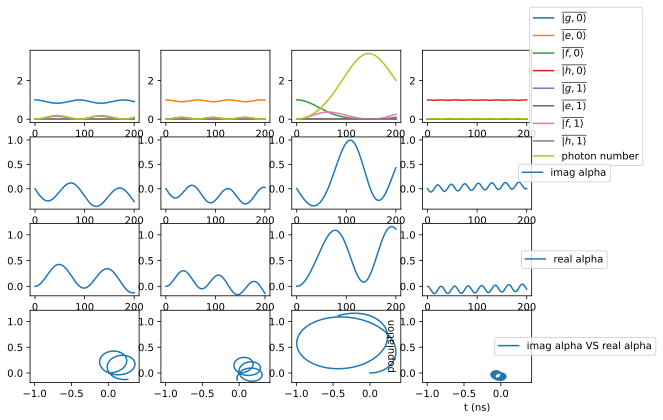

In [5]:
plot_population_and_alpha(results,idxs,product_states,tlist,dominant_freq,nlevels = 4)

In [6]:
make_husimi_gif_qt_version(tlist,results,qubit_levels,osc_levels,product_to_dressed,dominant_freq=0.0)

finished 41 out of 40


In [10]:
make_husimi_gif_qt_version(tlist,results,qubit_levels,osc_levels,product_to_dressed,dominant_freq=dominant_freq)

finished 41 out of 40


In [11]:
make_husimi_gif_zhen_yi_qi_version(tlist,results,qubit_levels,osc_levels,hilbertspace,dominant_freq)


finished 41 out of 40
